In [1]:
import numpy as np
import pandas as pd
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rc

from sklearn.model_selection import train_test_split

# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

from impyute.imputation.cs import fast_knn
import sys
sys.setrecursionlimit(100000) 

In [4]:
data_all = pd.read_csv('cosmos.v1.3.8.cat',delim_whitespace=True)

In [5]:
data_all.head()

,id,x,y,ra,dec,SEflags,iso_area,fap_Ksall,eap_Ksall,apcorr,...,wmin_jhk,wmin_hst,wmin_irac,wmin_all,star,nearstar,use,snr,use_nosnr,z_spec
0,1,2825.045,48.504,150.128601,2.174722,0,6.0,0.321644,0.110580,1.646582,...,1.09,0.0,1.04,0.60,0,0,0,4.354714,0,-99.0
1,2,2056.510,49.244,150.160645,2.174749,0,14.0,0.535205,0.115497,1.391211,...,1.11,0.0,0.94,0.55,0,0,0,5.001919,0,-99.0
2,3,2972.610,51.087,150.122452,2.174830,0,10.0,0.500944,0.107069,1.416701,...,1.09,0.0,0.79,0.64,0,0,0,4.630170,0,-99.0
3,4,4207.035,51.665,150.070969,2.174860,0,18.0,0.618443,0.118782,1.235780,...,1.06,0.0,0.90,0.52,1,0,0,4.740365,0,-99.0
4,5,1371.338,47.309,150.189209,2.174664,0,39.0,1.036439,0.119941,1.223002,...,1.14,0.0,1.00,0.51,1,0,0,9.145858,0,-99.0


In [6]:
for i in range(24):
    print( data_all.columns[i*6:(i+1)*6])
print( data_all.columns[24*6:148])

Index(['id', 'x', 'y', 'ra', 'dec', 'SEflags'], dtype='object')
Index(['iso_area', 'fap_Ksall', 'eap_Ksall', 'apcorr', 'Ks_ratio',
       'fapcirc09_Ksall'],
      dtype='object')
Index(['eapcirc09_Ksall', 'apcorr09', 'fcirc09_Ksall', 'ecirc09_Ksall',
       'fauto_Ksall', 'flux50_radius'],
      dtype='object')
Index(['a_vector', 'b_vector', 'kron_radius', 'f_Ksall', 'e_Ksall', 'w_Ksall'], dtype='object')
Index(['f_B', 'e_B', 'w_B', 'f_G', 'e_G', 'w_G'], dtype='object')
Index(['f_I', 'e_I', 'w_I', 'f_IA427', 'e_IA427', 'w_IA427'], dtype='object')
Index(['f_IA484', 'e_IA484', 'w_IA484', 'f_IA505', 'e_IA505', 'w_IA505'], dtype='object')
Index(['f_IA527', 'e_IA527', 'w_IA527', 'f_IA624', 'e_IA624', 'w_IA624'], dtype='object')
Index(['f_IA709', 'e_IA709', 'w_IA709', 'f_IA738', 'e_IA738', 'w_IA738'], dtype='object')
Index(['f_R', 'e_R', 'w_R', 'f_U', 'e_U', 'w_U'], dtype='object')
Index(['f_V', 'e_V', 'w_V', 'f_Rp', 'e_Rp', 'w_Rp'], dtype='object')
Index(['f_Z', 'e_Z', 'w_Z', 'f_Zp', 'e_Zp

In [7]:
for col in data_all.columns:
    num =np.count_nonzero(data_all[col] == -99)
    if (num != 0):
        print('{0} is missing {1} values'.format(col,num))

fap_Ksall is missing 18 values
eap_Ksall is missing 18 values
fapcirc09_Ksall is missing 18 values
eapcirc09_Ksall is missing 18 values
fcirc09_Ksall is missing 18 values
ecirc09_Ksall is missing 18 values
f_Ksall is missing 3 values
e_Ksall is missing 3 values
f_Hl is missing 1677 values
e_Hl is missing 1677 values
f_Hs is missing 1727 values
e_Hs is missing 1727 values
f_J1 is missing 1488 values
e_J1 is missing 1488 values
f_J2 is missing 1790 values
e_J2 is missing 1790 values
f_J3 is missing 1759 values
e_J3 is missing 1759 values
f_Ks is missing 1582 values
e_Ks is missing 1582 values
f_NB118 is missing 3228 values
e_NB118 is missing 3228 values
f_NB209 is missing 2885 values
e_NB209 is missing 2885 values
f_F125W is missing 6083 values
e_F125W is missing 6083 values
f_F140W is missing 8708 values
e_F140W is missing 8708 values
f_F160W is missing 5857 values
e_F160W is missing 5857 values
f_F606W is missing 3366 values
e_F606W is missing 3366 values
f_F814W is missing 3329 values

In [8]:
stars = np.array(data_all.index[data_all['star']==1].tolist())

In [9]:
nostar = data_all.drop(stars,axis=0)

In [10]:
nostar.to_csv('nostar.csv', index = False)

In [6]:
nostar  = pd.read_csv('nostar.csv')

In [12]:
fld1 = nostar.filter(['id','f_B','f_G','f_I', 'f_R','f_U', 'f_V','f_Z',
                       'z_spec'], axis=1)

In [14]:
fld1.to_csv('filtered1.csv', index = False)

In [15]:
fld2 = nostar.filter(['id','a_vector','b_vector','f_B','f_G','f_I', 'f_R','f_U', 'f_V','f_Z',
                       'z_spec'], axis=1)
fld2.to_csv('filtered2.csv', index = False)
zspec = fld2[(fld2['z_spec']!=-99)]
zspec.to_csv('filtered2_zspec.csv', index = False)

In [19]:
zspec = nostar[(nostar['z_spec']!=-99)]
zspec.to_csv('nostar_zspec.csv',index = False)

In [2]:
zspec = pd.read_csv('nostar_zspec.csv')
zspec.replace({-99.0000 : np.NaN}, inplace=True)
#zspec.head()

In [3]:
filter_col = [col for col in zspec if col.startswith('f_')]
len(filter_col)

38

In [4]:
def retNmissing(zspec,filter_col):
    num = np.zeros((len(filter_col),2)).astype(int)
    i=0
    for col in filter_col:
        num[i,1] =np.count_nonzero(np.isnan(zspec[col]))
        if (num[i,1] != 0):
            print('{0} is missing {1} values'.format(col,num[i,1]))
        num[i,0] = i
        i+=1
    num = num[np.argsort( num[:,1] )]
    empts = num[num[:,1]!= 0]
    inds = num[num[:,1]== 0][:,0]
    labs = [filter_col[i] for i in inds]
    return labs, empts

In [5]:
labs, num = retNmissing(zspec,filter_col)

f_Hl is missing 1 values
f_Hs is missing 1 values
f_J1 is missing 1 values
f_J2 is missing 2 values
f_J3 is missing 1 values
f_Ks is missing 1 values
f_NB118 is missing 19 values
f_NB209 is missing 21 values
f_F125W is missing 8 values
f_F140W is missing 75 values
f_F160W is missing 3 values
f_F606W is missing 2 values
f_F814W is missing 2 values
f_UVISTA_Ks is missing 5 values
f_UVISTA_Y is missing 5 values


In [6]:
prev = np.vstack((zspec.mean(axis = 0, skipna = True)[filter_col],zspec.std(axis = 0, skipna = True)[filter_col]))

#newzspec = zspec[filter_col].sub(means)
#newzspec = zspec[filter_col].sub(means).divide(stds)
#newzspec.std(axis = 0, skipna=True)

In [7]:
def impudf(zspecold,labs,num,filter_col,k):
    dim = len(num[:,0])
    for i in range(dim):
        #zspecold[labs] += 1e-10
        #print(zspecold[labs])
        #zspecold[labs] = np.log(zspecold[labs])
        means = zspecold.mean(axis = 0, skipna = True)[labs]
        #print(means)
        stds = zspecold.std(axis = 0, skipna = True)[labs]
        #print(stds)
        zspec = zspecold[labs].sub(means).divide(stds)
        #print(np.vstack((zspec.mean(axis = 0, skipna = True)[labs],zspec.std(axis = 0, skipna = True)[labs])))
        #print(np.vstack((zspecold.mean(axis = 0, skipna = True)[labs],zspecold.std(axis = 0, skipna = True)[labs])))
        base = zspec.filter(labs, axis=1).to_numpy()
        new = zspecold.filter([filter_col[num[i,0]]], axis=1).to_numpy()
        #inds = np.array(np.where(np.isnan(new)))[0,:]
        #print(inds)
        #print(new[inds])
        alltog = np.hstack((new,base))
        #print(base.shape)
        #print(alltog.shape)
        allimpu =fast_knn(alltog, k=k, p=2)
        #print(allimpu[inds,0])
        zspecold[filter_col[num[i,0]]] = allimpu[:,0]
        labs = np.hstack((labs, filter_col[num[i,0]]))
        #print(labs)

In [8]:
impudf(zspec,np.hstack((labs,'z_spec',['a_vector','b_vector'])),num,filter_col,5)

In [396]:
def impulogdf(zspecold,labs,num,filter_col,k):
    dim = len(num[:,0])
    for col in filter_col:
        #l = zspecold[col]<=0
        #print(zspecold[l][col])
        zspecold.loc[zspecold[col]<=0,col]=1e-10
        #print(zspecold[l][col])
    for i in range(dim):
        #zspecold[labs] += 1e-10
        #print(zspecold[labs])
        zspec = np.log(zspecold[labs])
        #print(zspec[labs])
        means = zspec.mean(axis = 0, skipna = True)[labs]
        #print(means)
        stds = zspec.std(axis = 0, skipna = True)[labs]
        #print(stds)
        zspec = zspec[labs].sub(means).divide(stds)
        #print(zspec[labs])
        #print(np.vstack((zspec.mean(axis = 0, skipna = True)[labs],zspec.std(axis = 0, skipna = True)[labs])))
        #print(np.vstack((zspecold.mean(axis = 0, skipna = True)[labs],zspecold.std(axis = 0, skipna = True)[labs])))
        base = zspec.filter(labs, axis=1).to_numpy()
        new = np.log(zspecold.filter([filter_col[num[i,0]]], axis=1).to_numpy())
        #inds = np.array(np.where(np.isnan(new)))[0,:]
        #print(inds)
        #print(new[inds])
        alltog = np.hstack((new,base))
        #print(base.shape)
        #print(alltog.shape)
        allimpu =fast_knn(alltog, k=k, p=2)
        #print(allimpu[inds,0])
        zspecold[filter_col[num[i,0]]] = np.exp(allimpu[:,0])
        labs = np.hstack((labs, filter_col[num[i,0]]))
        #print(labs)

In [399]:
impulogdf(zspec,np.hstack((labs)),num,filter_col,15)

In [9]:
labs, num = retNmissing(zspec,filter_col)

In [10]:
new = np.vstack((zspec.mean(axis = 0, skipna = True)[filter_col],zspec.std(axis = 0, skipna = True)[filter_col]))
print(new - prev)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -3.10166276e-04 -2.24095289e-04  1.26774202e-03
   3.26078581e-03  8.69590986e-04  4.56245178e-04  3.75499221e-04
   1.87121314e-03  3.67162909e-04  8.72302970e-04 -1.40354781e-03
  -1.59269508e-03 -4.36178571e-04  0.00000000e+00  0.00000000e+00
  -7.14388619e-03 -5.57224141e-03  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -2.75831928e-01 -2.59371097e-01 -1.52338514e-01
  -3.48507923e-01 -2.07315966e-01 -3.1780

In [11]:
def splits(zspec, t_size, seed,keys):
    #print(keys)
    npzspec = zspec.filter(keys, axis=1).to_numpy()
    npzspec_l = zspec.filter(['z_spec'], axis=1).to_numpy()
    npzspec_id = zspec.filter(['id'], axis=1).to_numpy()
    train, test, train_l, test_l= train_test_split(npzspec, npzspec_l.ravel(),test_size = t_size, random_state = seed)
    return train, test, train_l, test_l

In [12]:
def crossets(train, train_l, n):
    s = np.size(train_l)
    step = int(s/n)
    p=np.split(train,[step*(i+1) for i in range(n-1) ])
    pl=np.split(train_l,[step*(i+1) for i in range(n-1) ])
    res = [np.vstack([p[i] for i in range(n) if i!=0])]
    resl = [np.hstack([pl[i] for i in range(n) if i!=0])]
    for j in range(n-1):
        res.append(np.vstack([p[i] for i in range(n) if i!=(j+1)]))
        resl.append(np.hstack([pl[i] for i in range(n) if i!=(j+1)]))
    return res,resl

In [13]:
def save_tree(idtosave, train, test, train_l, test_l):

    # Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = 1000, random_state = seed,min_samples_split =4)
    #, max_depth=3

    # Train the model on training data
    rf.fit(train, train_l);
    # Use the forest's predict method on the test data
    predictions = rf.predict(test)

    # Calculate the absolute errors
    errors = abs(predictions - test_l)

    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2))
    #plt.scatter(np.linspace(0,errors.size, errors.size),errors)
    #plt.figure()
    #plt.scatter(predictions, test_l)
    #plt.xticks(np.arange(0,5, 0.5))
    #plt.grid(True)
    #plt.savefig(idtosave)
    return rf

Mean Absolute Error: 0.37
Mean Absolute Error: 0.4
Mean Absolute Error: 0.36
Mean Absolute Error: 0.39
Mean Absolute Error: 0.37


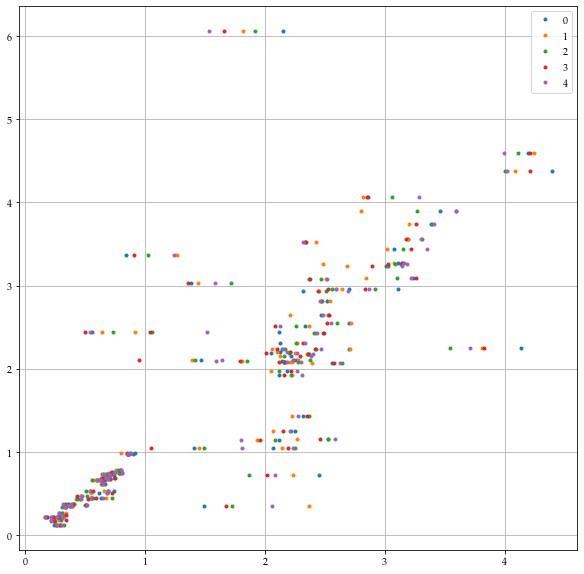

In [14]:
seed = 6
percent = 0.2
forests = 5
keys = np.hstack((['a_vector','b_vector'],filter_col))
train, test, train_l, test_l=splits(zspec, percent, seed,keys)
res,resl = crossets(train,train_l,forests)
rf = []
for i in range(np.size(resl)):
    rf.append(save_tree('tree{0}_p{1}_s{2}_f{3}.png'.format(i,percent*100,seed,forests),
                        res[i], test, resl[i], test_l))

plt.figure(figsize=(10,10))
for i in range(np.size(resl)):
    plt.plot(rf[i].predict(test), test_l,'.',label = str(i))
plt.grid(True)
plt.legend()
plt.savefig('all_f{0}_s{1}_p{2}_Log15-leaf4.png'.format(forests,seed,int(percent*100)))

Mean Absolute Error: 0.3
Mean Absolute Error: 0.26
Mean Absolute Error: 0.28
Mean Absolute Error: 0.29
Mean Absolute Error: 0.28
Mean Absolute Error: 0.29
Mean Absolute Error: 0.25
Mean Absolute Error: 0.29
Mean Absolute Error: 0.26
Mean Absolute Error: 0.25


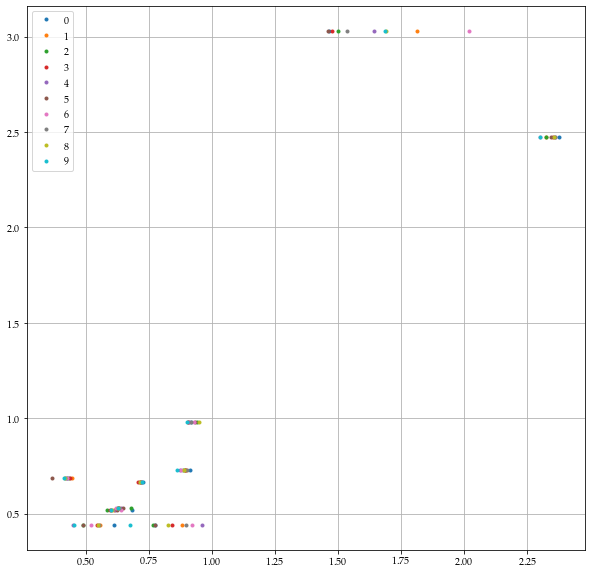

In [391]:
seed = 2
percent = 0.02
forests = 10
keys = np.hstack((['a_vector','b_vector'],filter_col))
train, test, train_l, test_l=splits(zspec, percent, seed,keys)
res,resl = crossets(train,train_l,forests)
rflin = []
for i in range(np.size(resl)):
    rflin.append(save_tree('tree{0}_p{1}_s{2}_f{3}.png'.format(i,percent*100,seed,forests),
                        res[i], test, resl[i], test_l))

plt.figure(figsize=(10,10))
for i in range(np.size(resl)):
    plt.plot(rflin[i].predict(test), test_l,'.',label = str(i))
plt.grid(True)
plt.legend()
plt.savefig('all_f{0}_s{1}_p{2}_Lin.png'.format(forests,seed,int(percent*100)))

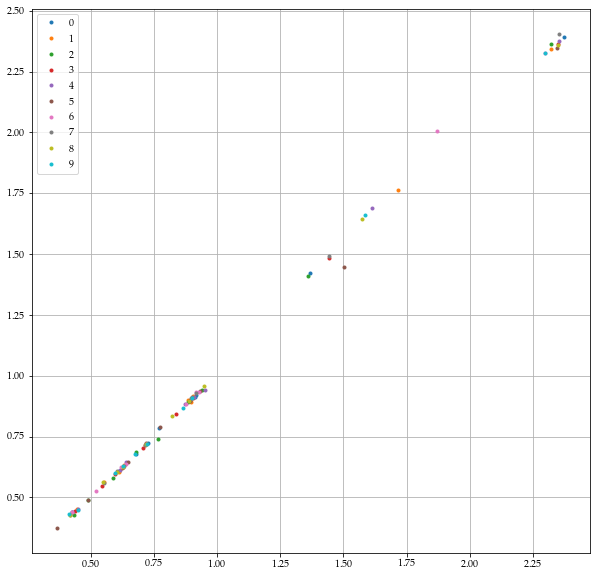

In [403]:
plt.figure(figsize=(10,10))
for i in range(np.size(resl)):
    plt.plot(rflin[i].predict(test), rf[i].predict(test),'.',label = str(i))
plt.grid(True)
plt.legend()
plt.savefig('comp15.png'.format(forests,seed,int(percent*100)))

In [305]:
# Get numerical feature importances
importances = list(rf[4].feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(keys, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)


# Print out the feature and importances 
[print('Variable: {:30} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: f_Z                            Importance: 0.1926
Variable: f_IA738                        Importance: 0.1469
Variable: f_I                            Importance: 0.116
Variable: f_Zp                           Importance: 0.0758
Variable: f_U                            Importance: 0.0757
Variable: f_IRAC_45                      Importance: 0.0452
Variable: f_UVISTA_J                     Importance: 0.0436
Variable: f_F814W                        Importance: 0.0387
Variable: f_J1                           Importance: 0.0249
Variable: f_Rp                           Importance: 0.0219
Variable: f_G                            Importance: 0.0205
Variable: f_B                            Importance: 0.0171
Variable: f_IA484                        Importance: 0.0144
Variable: f_IA505                        Importance: 0.0138
Variable: f_IA527                        Importance: 0.0138
Variable: f_F125W                        Importance: 0.0134
Variable: f_IA427                        

In [341]:
for col in filter_col:
    print(zspec[(zspec[col]<0)][[col,col.replace('f','e')]])

Empty DataFrame
Columns: [f_Ksall, e_Ksall]
Index: []
          f_B       e_B
133 -0.041225  0.027403
223 -0.020498  0.025217
229 -0.029409  0.035211
258 -0.009960  0.023539
267 -0.033437  0.025667
273 -0.023511  0.022871
297 -0.020148  0.023519
448 -0.020827  0.023568
          f_G       e_G
267 -0.008053  0.034704
Empty DataFrame
Columns: [f_I, e_I]
Index: []
      f_IA427   e_IA427
7   -0.051345  0.091177
223 -0.097601  0.098600
229 -0.130133  0.138415
239 -0.179584  0.085424
260 -0.030303  0.113995
297 -0.093569  0.090960
408 -0.136448  0.084249
438 -0.070728  0.094829
440 -0.241500  0.097507
448 -0.064171  0.091132
454 -0.065139  0.109807
      f_IA484   e_IA484
223 -0.052594  0.084787
229 -0.019706  0.120269
258 -0.016540  0.078941
260 -0.015387  0.098746
267 -0.175610  0.086154
422 -0.071588  0.109151
448 -0.015828  0.078615
      f_IA505   e_IA505
229 -0.196574  0.141134
258 -0.085897  0.092415
269 -0.117975  0.102471
286 -0.117842  0.095084
297 -0.043052  0.092382
352 -0.08087

In [342]:
for col in filter_col:
    print(zspec[(zspec[col]<0)][col]/zspec[(zspec[col]<0)][col.replace('f','e')])

Series([], dtype: float64)
133   -1.504400
223   -0.812858
229   -0.835221
258   -0.423119
267   -1.302758
273   -1.028004
297   -0.856678
448   -0.883683
dtype: float64
267   -0.232038
dtype: float64
Series([], dtype: float64)
7     -0.563140
223   -0.989863
229   -0.940166
239   -2.102270
260   -0.265831
297   -1.028685
408   -1.619582
438   -0.745853
440   -2.476739
448   -0.704155
454   -0.593219
dtype: float64
223   -0.620314
229   -0.163848
258   -0.209521
260   -0.155825
267   -2.038325
422   -0.655856
448   -0.201338
dtype: float64
229   -1.392822
258   -0.929473
269   -1.151299
286   -1.239346
297   -0.466018
352   -0.924878
434   -0.196712
dtype: float64
260   -0.295366
269   -1.238446
273   -0.007383
dtype: float64
229   -0.050725
273   -0.299116
352   -0.226655
dtype: float64
229   -0.238568
dtype: float64
229   -0.101947
dtype: float64
Series([], dtype: float64)
7     -1.309096
112   -0.505845
133   -1.158631
223   -2.338909
239   -0.712022
258   -0.665041
267   -1.144523


In [8]:
unique, counts = np.unique(data_all['star'], return_counts=True)
dict(zip(unique, counts))

{0: 20213, 1: 573}

In [9]:
unique, counts = np.unique(data_all['nearstar'], return_counts=True)
dict(zip(unique, counts))

{0: 19584, 1: 1202}

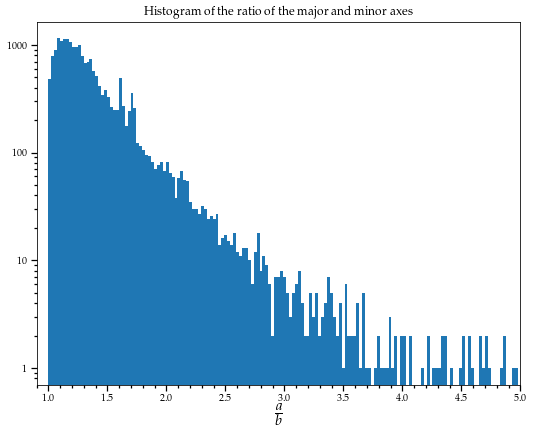

In [10]:
fig = plt.figure(num = 2,figsize=(8,6))
ax = fig.add_axes([0.1,0.1,0.84,.84])
ratio = np.array(data_all['a_vector']/data_all['b_vector'])
ratiocut = ratio[ratio < 10]
hist, bins = np.histogram(ratiocut, bins = 'fd')
ax.bar(0.5*(bins[1:]+bins[:-1]), hist, width = 0.025)
ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlim((0.9,5))
ax.tick_params(which='both', width=1.25)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3)
rc('font', family='serif')
ax.set_xlabel(r'$\frac{a}{b}$',size = 20)
ax.set_title(r'Histogram of the ratio of the major and minor axes')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.minorticks_on()
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
fig.savefig('axis_ratio_hist.png',dpi=400)

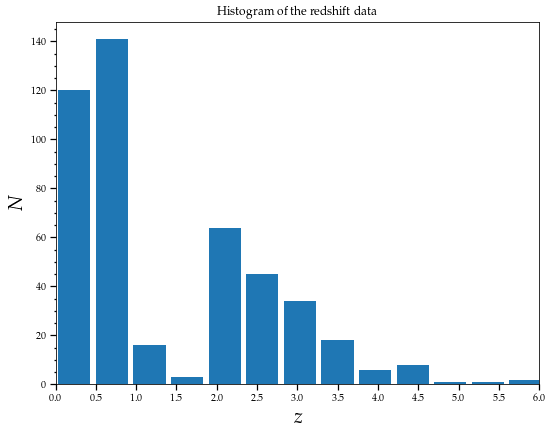

In [26]:
fig = plt.figure(num = 2,figsize=(8,6))
ax = fig.add_axes([0.1,0.1,0.84,.84])
hist, bins = np.histogram(zspec['z_spec'].to_numpy(), bins = 'fd')
ax.bar(0.5*(bins[1:]+bins[:-1]), hist, width = 0.4)
# ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlim((0,6))
ax.tick_params(which='both', width=1.25)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.tick_params(which='major', length=6)
# ax.tick_params(which='minor', length=3)
rc('font', family='serif')
ax.set_xlabel(r'$z$',size = 20)
ax.set_ylabel(r'$N$',size = 20)
ax.set_title(r'Histogram of the redshift data')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.minorticks_on()
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
fig.savefig('galaxy in bin.png',dpi=200)

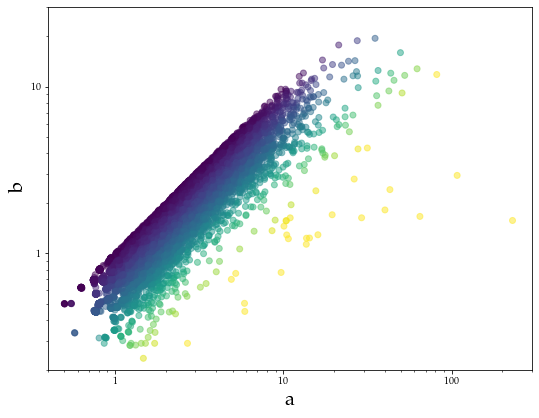

In [11]:
fig = plt.figure(num = 1,figsize=(8,6))
ax = fig.add_axes([0.1,0.1,0.84,.84])
ax.scatter(data_all['a_vector'], data_all['b_vector'],marker = 'o', c=ratio ,
           norm=LogNorm(vmin=np.percentile(ratio,.1),vmax =np.percentile(ratio,99.9)) ,cmap ='viridis', alpha = 0.5 )
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'a ',size = 20)
ax.set_ylabel(r'b ',size = 20)
ax.set_xlim((0.4,300))
ax.set_ylim((0.2,30))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
fig.savefig('a_b.png',dpi=400)

In [12]:
data_all.describe()

,id,x,y,ra,dec,SEflags,iso_area,fap_Ksall,eap_Ksall,apcorr,...,wmin_jhk,wmin_hst,wmin_irac,wmin_all,star,nearstar,use,snr,use_nosnr,z_spec
count,20786.000000,20786.000000,20786.000000,20786.000000,20786.000000,20786.000000,20786.000000,20786.000000,20786.000000,20786.000000,...,20786.000000,20786.000000,20786.000000,20786.000000,20786.000000,20786.000000,20786.000000,20786.000000,20786.000000,20786.000000
mean,10393.500000,2812.783099,2791.473141,150.129123,2.289005,0.960454,141.692052,16.374999,0.008897,1.268564,...,0.944796,0.550115,0.964596,0.820669,0.027567,0.057827,0.621765,202.047987,0.756278,-96.753959
std,6000.545684,1440.893832,1550.373529,0.060082,0.064596,1.595904,469.204430,257.483525,2.915016,0.189659,...,0.175116,0.477138,0.123698,0.234407,0.163731,0.233422,0.484958,3315.171817,0.429337,14.849310
min,1.000000,163.392000,47.309000,150.024734,2.174664,0.000000,1.000000,-99.000000,-99.000000,0.988129,...,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-99.000000
25%,5197.250000,1554.670250,1429.259000,150.076862,2.232250,0.000000,19.000000,0.468875,0.079188,1.122124,...,0.940000,0.000000,0.870000,0.730000,0.000000,0.000000,0.000000,5.640533,1.000000,-99.000000
50%,10393.500000,2868.060000,2789.176500,150.126816,2.288911,0.000000,48.500000,0.904222,0.083591,1.200676,...,0.990000,0.910000,0.960000,0.870000,0.000000,0.000000,1.000000,10.328365,1.000000,-99.000000
75%,15589.750000,4066.121000,4137.333500,150.181591,2.345076,3.000000,120.000000,2.545721,0.098253,1.382663,...,1.040000,0.980000,1.060000,0.990000,0.000000,0.000000,1.000000,28.810877,1.000000,-99.000000
max,20786.000000,5316.358000,5558.000000,150.239578,2.404277,19.000000,26678.000000,12351.770000,0.237564,1.648597,...,1.220000,1.490000,1.380000,1.250000,1.000000,1.000000,1.000000,149626.000000,1.000000,6.060000


In [82]:
null_data = data_all[data_all.isnull()]

In [89]:
data_all.iloc[-99]

id                  20688.000000
x                    1263.097000
y                    4732.265000
ra                    150.193756
dec                     2.369859
SEflags                 3.000000
iso_area               36.000000
fap_Ksall               0.623345
eap_Ksall               0.087421
apcorr                  1.301185
Ks_ratio                2.120933
fapcirc09_Ksall         0.719731
eapcirc09_Ksall         0.082436
apcorr09                1.646582
fcirc09_Ksall           1.185095
ecirc09_Ksall           0.135738
fauto_Ksall             1.016052
flux50_radius           2.360000
a_vector                1.975000
b_vector                1.600000
kron_radius             4.302000
f_Ksall                 1.322072
e_Ksall                 0.167680
w_Ksall                 0.960000
f_B                     0.017706
e_B                     0.023579
w_B                     1.000000
f_G                     0.043808
e_G                     0.031347
w_G                     1.000000
          

In [6]:
#shuffling routine
a = np.zeros((5,3))
for i in range(5): a[i,:] = i*10
b = np.zeros((5,1))
for i in range(5): b[i,:] = i*10

In [17]:
indices = np.random.permutation(a.shape[0])
a = a[indices]
b = b[indices]

In [18]:
a

array([[40., 40., 40.],
       [ 0.,  0.,  0.],
       [10., 10., 10.],
       [30., 30., 30.],
       [20., 20., 20.]])

In [19]:
b

array([[40.],
       [ 0.],
       [10.],
       [30.],
       [20.]])